Здесь будем фигачить признаки для деревьев, поэтому скоррелированные не выкидываем

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tnrange, tqdm_notebook
import gc

In [2]:
from scipy import stats

In [3]:
sns.set_context('talk')

In [4]:
pd.set_option('display.max_columns', 500)

In [5]:
import warnings
warnings.filterwarnings('ignore', message='Changing the shape of non-C contiguous array')

# Read the data

In [6]:
test = pd.read_csv('csv/ech_test.csv', sep=';', index_col='id')
train = pd.read_csv('csv/ech_apprentissage.csv', sep=';', index_col='id')

/home/alexey/.environments/ml/lib/python3.4/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Graphs

In [7]:
train.columns

Index(['annee_naissance', 'annee_permis', 'marque', 'puis_fiscale', 'anc_veh',
       'codepostal', 'energie_veh', 'kmage_annuel', 'crm', 'profession',
       'var1', 'var2', 'var3', 'var4', 'var5', 'var6', 'var7', 'var8', 'var9',
       'var10', 'var11', 'var12', 'var13', 'var14', 'var15', 'var16', 'var17',
       'var18', 'var19', 'var20', 'var21', 'var22', 'prime_tot_ttc'],
      dtype='object')

Заменим NR на NaN

In [8]:
train.replace('NR', np.NaN, inplace=True)
test.replace('NR', np.NaN, inplace=True)

Заменим ARMEE в codepostal на -1

In [9]:
train.loc[train.codepostal == 'ARMEE', 'codepostal'] = '-1'

In [10]:
train.loc[train.codepostal == '-1', 'codepostal']

id
46294    -1
46295    -1
46296    -1
Name: codepostal, dtype: object

Переведём codepostal в числа

In [11]:
train.codepostal = pd.to_numeric(train.codepostal)

In [12]:
test.codepostal.dtype

dtype('int64')

С тестом всё норм

Разделим codepostal на часть, относящуюся к региону, и на остальное. Учтём всякие крайние случаи типа заморских территорий.

In [13]:
def split_postcode(df):
    df['department'] = df['codepostal'] // 1000
    df['subreg'] = df['codepostal'] % 1000
    overseas = (df['department'] == 98) | (df['department'] == 97)
    df.ix[overseas, 'department'] = df['codepostal'] // 100
    df.ix[overseas, 'subreg'] = df['codepostal'] % 100
    return df.drop('codepostal', axis=1)

In [14]:
train = split_postcode(train)

In [15]:
test = split_postcode(test)

Посмотрим на категориальные

In [16]:
categorical = []
for col in train.columns:
    if train[col].dtype not in ['int64', 'float64']:
        print(col, train[col].dtype)
        categorical.append(col)

marque object
energie_veh object
profession object
var6 object
var7 object
var8 object
var14 object
var16 object


In [17]:
for col in categorical:
    print(col, '\n', set(train[col]), '\n\n')

marque 
 {nan, 'VOLKSWAGEN', 'MAZDA', 'BENTLEY', 'PLYMOUTH', 'MG', 'PONTIAC', 'TALBOT', 'VEH SPECIAL', 'TVR', 'DAF', 'FORD', 'STRAUBENHARDT', 'PIAGGIO', 'MASERATI', 'MORGAN', 'RAYTON FISSORE', 'HYUNDAI', 'DACIA', 'SAVIEM', 'ROVER', 'SATURN', 'MATRA', 'PININFARINA', 'NSU', 'LAND-ROVER', 'DETHLEFFS', 'DE LOREAN', 'AUVERLAND', 'UNIMOG', 'DANGEL', 'SECMA', 'LOHR', 'DAEWOO', 'GRANDIN', 'LOTUS', 'AUSTIN-HEALEY', 'TATA', 'CARBODIES', 'BUICK', 'RAMBLER', 'TRIUMPH', 'LAMBORGHINI', 'ENGIN LOISIRS', 'SKODA', 'LEXUS', 'TOYOTA', 'FIAT', 'SEAT', 'AUTO-UNION', 'PANTHER', 'AUTOBIANCHI', 'PONCIN', 'JEEP', 'RENAULT', 'CATERHAM', 'ROLLS ROYCE', 'NECKAR', 'MERCURY', 'STEYR PUCH', 'ARO', 'UMM', 'LINCOLN', 'ALFA ROMEO', 'DONKERVOORT', 'MITSUBISHI', 'ASTON MARTIN', 'AMPHICAR', 'JAGUAR', 'JIDE', 'CHENARD ET WALKER', 'TEILHOL', 'CITROEN', 'GME', 'NISSAN', 'FSO', 'CADILLAC', 'SAAB', 'BREMACH', 'SSANGYONG', 'CHRYSLER', 'VOLVO', 'DODGE', 'SUZUKI', 'EAGLE', 'DAIHATSU', 'ACMA', 'DATSUN', 'INTERNATIONAL', 'ENGIN SPE

Переведём в численные те признаки, которые посчитались за категориальные, потому что в них был NR (var7, var16). 

In [18]:
train.var7 = pd.to_numeric(train.var7)
train.var16 = pd.to_numeric(train.var16)

In [19]:
test.var7 = pd.to_numeric(test.var7)
test.var16 = pd.to_numeric(test.var16)

Опять посмотрим, но сразу с тестом

In [20]:
categorical = []
bigX = pd.concat([train.drop('prime_tot_ttc', axis=1), test])
for col in bigX.columns:
    if bigX[col].dtype not in ['int64', 'float64']:
        categorical.append(col)
for col in categorical:
    s = set(bigX[col])
    print(col, len(s), '\n', s, '\n\n')        

marque 157 
 {nan, 'VOLKSWAGEN', 'MAZDA', 'BENTLEY', 'PLYMOUTH', 'MG', 'PONTIAC', 'TALBOT', 'VEH SPECIAL', 'GEELY', 'TVR', 'DAF', 'FORD', 'STRAUBENHARDT', 'PIAGGIO', 'MASERATI', 'MORGAN', 'RAYTON FISSORE', 'HYUNDAI', 'DACIA', 'SAVIEM', 'ROVER', 'SATURN', 'MATRA', 'PININFARINA', 'NSU', 'LAND-ROVER', 'DETHLEFFS', 'DE LOREAN', 'AUVERLAND', 'UNIMOG', 'DANGEL', 'SECMA', 'LOHR', 'DAEWOO', 'GRANDIN', 'LOTUS', 'AUSTIN-HEALEY', 'TATA', 'CARBODIES', 'BUICK', 'RAMBLER', 'TRIUMPH', 'LAMBORGHINI', 'ENGIN LOISIRS', 'SKODA', 'LEXUS', 'TOYOTA', 'FIAT', 'SEAT', 'AUTO-UNION', 'PANTHER', 'AUTOBIANCHI', 'PONCIN', 'JEEP', 'RENAULT', 'CATERHAM', 'ROLLS ROYCE', 'NECKAR', 'MERCURY', 'STEYR PUCH', 'ARO', 'UMM', 'LINCOLN', 'ALFA ROMEO', 'DONKERVOORT', 'MITSUBISHI', 'ASTON MARTIN', 'AMPHICAR', 'JAGUAR', 'JIDE', 'CHENARD ET WALKER', 'TEILHOL', 'CITROEN', 'GME', 'NISSAN', 'FSO', 'CADILLAC', 'SAAB', 'BREMACH', 'SSANGYONG', 'CHRYSLER', 'VOLVO', 'DODGE', 'SUZUKI', 'EAGLE', 'DAIHATSU', 'ACMA', 'DATSUN', 'INTERNATIONAL

В категорию маломощных категориалов выделяются var14, var6, energie_veh.

Средние var8, proffession

Большие marque

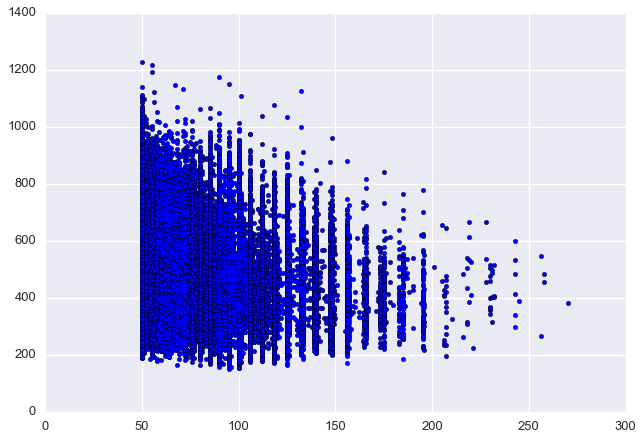

In [21]:
plt.scatter(train.crm, train.prime_tot_ttc / train.crm * 100)
plt.show()

In [22]:
train.drop('crm', axis=1).drop_duplicates().shape

(299987, 33)

In [23]:
train.drop_duplicates().shape

(299987, 34)

In [24]:
normed_train = train.drop('prime_tot_ttc', axis=1)
normed_train['target'] = np.log(train.prime_tot_ttc / train.crm * 100)

In [25]:
normed_train.drop('crm', axis=1).drop_duplicates().shape

(299987, 33)

In [26]:
normed_train.drop_duplicates().shape

(299987, 34)

Есть только полные дубли. Объектов с разным CRM, но с одинаковым таргетом нет

In [27]:
normed_train = train.drop(['prime_tot_ttc', 'crm'], axis=1)
normed_train['target'] = np.log(train.prime_tot_ttc / train.crm * 100)

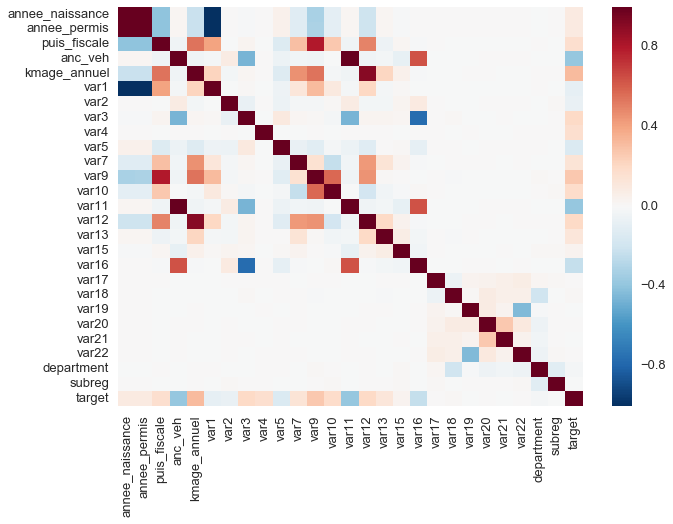

In [28]:
sns.heatmap(normed_train.corr())

## var1 -- стаж == 2016 - annee_permis

In [29]:
normed_train[['annee_permis', 'var1']].head()

,annee_permis,var1
id,,
1,2006.0,10.0
2,2006.0,10.0
3,2001.0,15.0
4,2006.0,10.0
5,2013.0,3.0


Думаю, annee_permis можно выкинуть, так как важны возраст и стаж

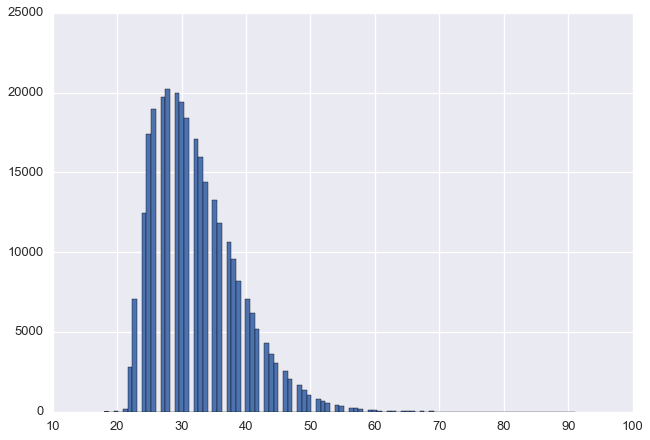

In [30]:
normed_train['age'] = 2016 - normed_train['annee_naissance']
normed_train.age.hist(bins=100)

In [31]:
normed_train.drop(['annee_naissance', 'annee_permis'], axis=1, inplace=True)

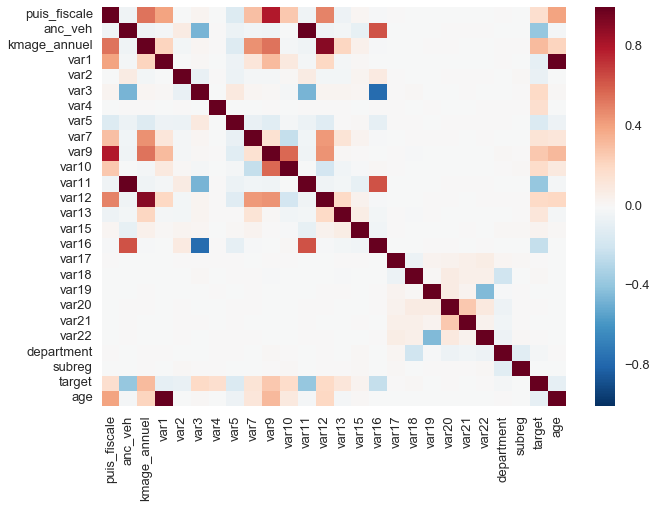

In [32]:
sns.heatmap(normed_train.corr())

In [33]:
normed_train.corr()['puis_fiscale'].sort_values()

var5           -0.133861
var13          -0.051338
var11          -0.045488
anc_veh        -0.045425
var16          -0.014450
var2           -0.006020
var21          -0.005166
var18          -0.005158
var19          -0.002424
subreg         -0.002264
var20          -0.001528
var22          -0.001318
var4           -0.000220
var17           0.000972
department      0.003248
var15           0.019341
var3            0.028392
target          0.171823
var10           0.268431
var7            0.300792
var1            0.398730
age             0.400239
var12           0.494775
kmage_annuel    0.544390
var9            0.803780
puis_fiscale    1.000000
Name: puis_fiscale, dtype: float64

Налог на мощность (puis_fiscale) зависит от мощности как $(P/40)^{1.6}$. var9 может быть мощностью

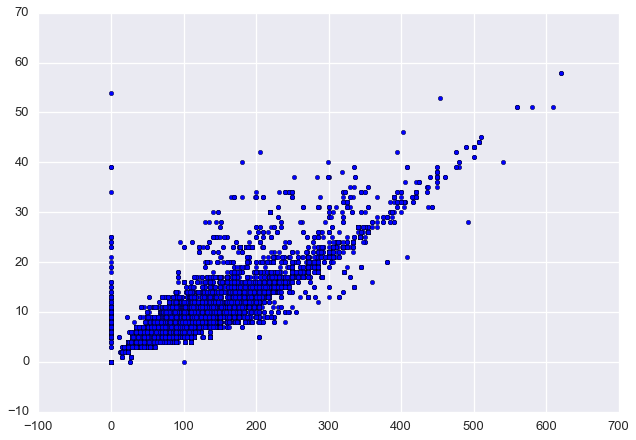

In [34]:
plt.scatter(normed_train.var9, normed_train.puis_fiscale)

In [35]:
stats.linregress(normed_train.var9, normed_train.puis_fiscale)

LinregressResult(slope=0.056943079878503423, intercept=1.2566075705838333, rvalue=0.80378024108838708, pvalue=0.0, stderr=7.6949823670234595e-05)

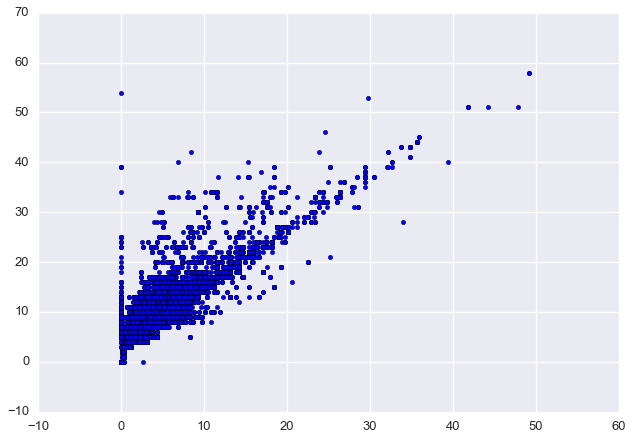

In [36]:
plt.scatter(np.power(normed_train.var9 * 0.736 / 40, 1.6), normed_train.puis_fiscale)

In [37]:
stats.linregress(np.power(normed_train.var9 * 0.736 / 40, 1.6), normed_train.puis_fiscale)

LinregressResult(slope=1.1828160832144912, intercept=3.5945370873033364, rvalue=0.83338935649205947, pvalue=0.0, stderr=0.001432151016607362)

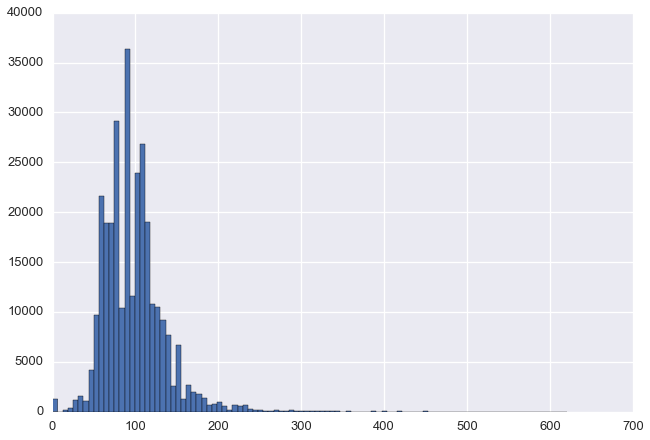

In [38]:
normed_train.var9.hist(bins=100)

## var9 -- мощность в лошадиных силах

In [39]:
normed_train.corr()['anc_veh'].sort_values()

var3           -0.461887
target         -0.387907
var15          -0.085359
var5           -0.055346
puis_fiscale   -0.045425
kmage_annuel   -0.043351
var12          -0.041996
var9           -0.040880
var7           -0.035949
var13          -0.024208
var1           -0.018797
age            -0.018597
var17          -0.007347
department     -0.003541
subreg         -0.002071
var19          -0.000791
var10          -0.000406
var18          -0.000244
var21           0.001245
var4            0.001688
var22           0.002601
var20           0.006100
var2            0.085120
var16           0.638843
var11           0.999028
anc_veh         1.000000
Name: anc_veh, dtype: float64

Мы знаем, что anc_veh -- возраст машины, что же тогда var11

In [40]:
normed_train[['anc_veh', 'var11']].head(10)

,anc_veh,var11
id,,
1,1,1
2,2,2
3,2,2
4,2,2
5,2,2
6,2,2
7,2,2
8,1,1
9,2,2


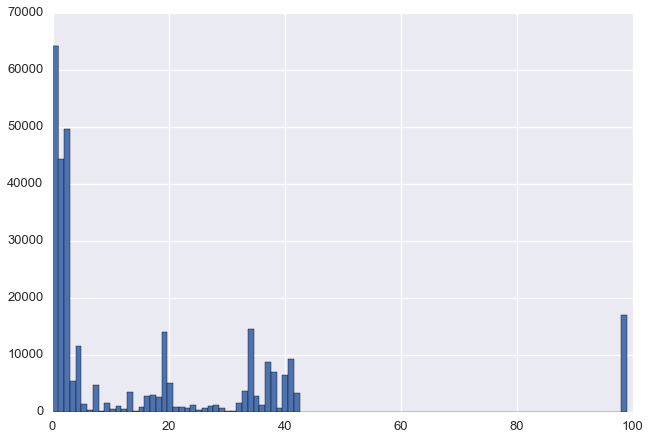

In [41]:
normed_train.anc_veh.hist(bins=100)

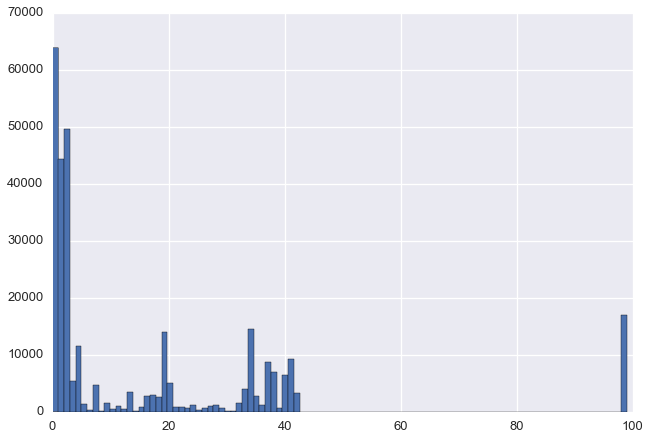

In [42]:
normed_train.var11.hist(bins=100)

In [43]:
(normed_train[normed_train.var11 != normed_train.anc_veh][['anc_veh', 'var11']]).drop_duplicates()

,anc_veh,var11
id,,
2548,0,33


Забавно, var11 почти полностью повторяет anc_veh. Только иногда встречаются пары (0, 33)

In [44]:
(normed_train[normed_train.var11 != normed_train.anc_veh][['anc_veh', 'var11']]).shape

(329, 2)

In [45]:
normed_train[normed_train.var11 == 33].shape

(4023, 32)

Ну нахер, просто выбросим var11

In [46]:
normed_train.drop(['var11'], axis=1, inplace=True)

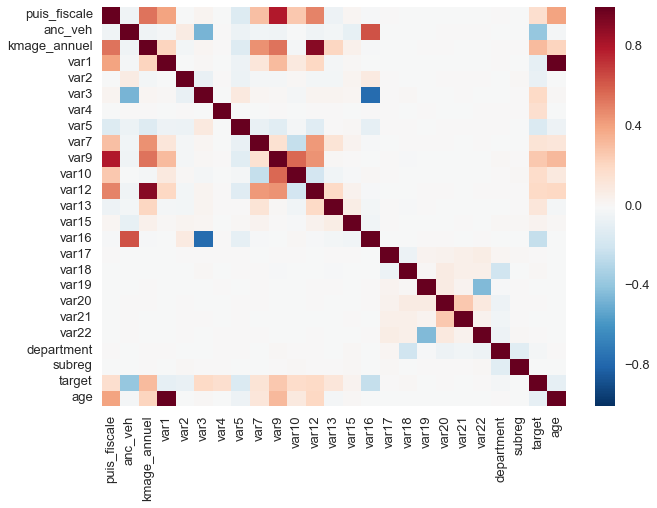

In [47]:
sns.heatmap(normed_train.corr())

## kmage_annuel -- ограничение на километраж за год

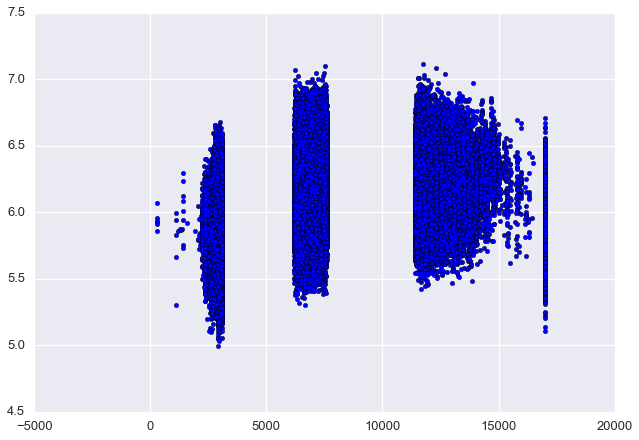

In [48]:
plt.scatter(normed_train.kmage_annuel, normed_train.target)

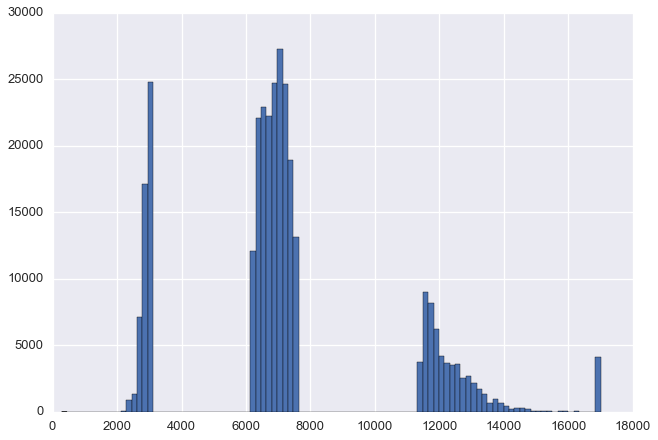

In [49]:
normed_train.kmage_annuel.hist(bins=100)

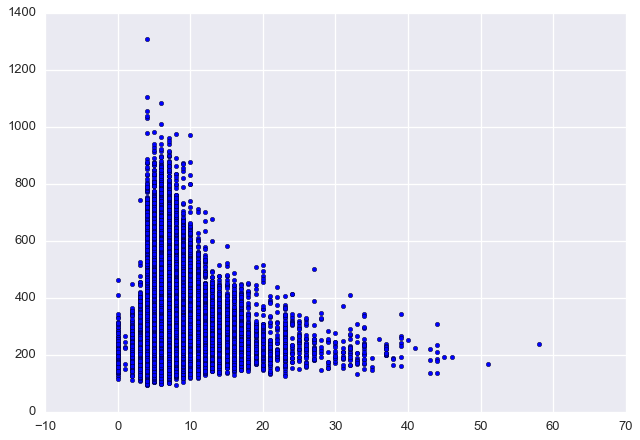

In [50]:
plt.scatter(train[train.anc_veh > 10].puis_fiscale, train[train.anc_veh > 10].prime_tot_ttc)

На форумах говорят, что от налога на лошадиные силы зависят линеные добавки к цене. Вот же зараза-то какая. Придётся вернуться к обычному таргету, да ещё вернуть crm

In [51]:
normed_train.target = train.prime_tot_ttc

In [52]:
normed_train['crm'] = train.crm

Ещё на форумах говорят, что сильно зависит от марки и возраста машины

In [53]:
normed_train.groupby(['marque', 'anc_veh', 'puis_fiscale', 'var1']).size().sort_values(ascending=False).head()

marque   anc_veh  puis_fiscale  var1
RENAULT  0        6             7.0     352
                                5.0     345
                                8.0     344
                  7             7.0     339
                  6             6.0     331
dtype: int64

In [54]:
df_index = (normed_train.marque == 'RENAULT') &\
           (normed_train.anc_veh == 0) & \
           (normed_train.puis_fiscale == 6) &\
           (normed_train.var1 > 3)
df_index = normed_train.puis_fiscale == 0
df = normed_train[df_index]

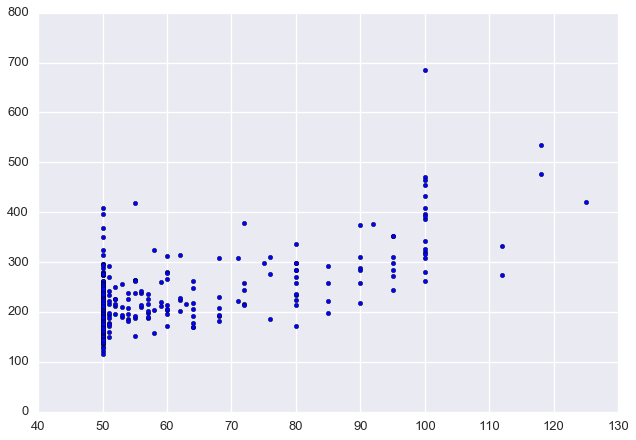

In [55]:
plt.scatter(df.crm, df.target)

In [56]:
slope, intercept, x, x, x = stats.linregress(df.crm, df.target)

In [57]:
slope, intercept

(2.9879360584322825, 48.626212080310438)

In [58]:
def mape(y_true, y_pred):
    y_pred = y_pred.reshape(y_true.shape)
    return -np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [59]:
mape(df.target, intercept + df.crm * slope)

-16.145963160189694

In [60]:
df_index = (normed_train.marque == 'RENAULT') &\
           (normed_train.anc_veh == 0) & \
           (normed_train.puis_fiscale == 6) &\
           (normed_train.var1 > 3)
df = normed_train[df_index]

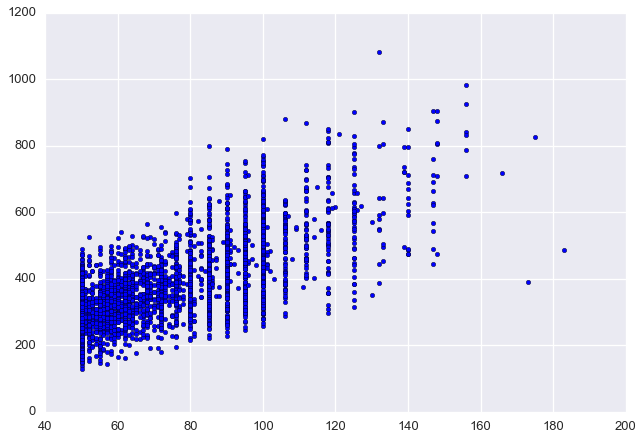

In [61]:
plt.scatter(df.crm, df.target)

In [62]:
slope, intercept, x, x, x = stats.linregress(df.crm, df.target)

In [63]:
slope, intercept

(4.0586888545035409, 79.250801256511295)

In [64]:
mape(df.target, intercept + df.crm * slope)

-17.603078443123767

In [65]:
var2more = [x for x in normed_train.columns if x.startswith('var')][1:]
var2more

['var2',
 'var3',
 'var4',
 'var5',
 'var6',
 'var7',
 'var8',
 'var9',
 'var10',
 'var12',
 'var13',
 'var14',
 'var15',
 'var16',
 'var17',
 'var18',
 'var19',
 'var20',
 'var21',
 'var22']

In [66]:
normed_train.groupby(var2more).size().sort_values(ascending=False).head()

var2  var3  var4  var5  var6  var7  var8  var9  var10  var12  var13  var14  var15  var16  var17  var18  var19  var20  var21  var22
3     372   0     1     B     7.0   H1    88    162    1370   5      E      3      1.0    1      22     0      0      1      6        3
5     372   0     1     B     8.0   M1    90    159    1265   4      F      2      1.0    1      25     0      0      1      1        3
2     372   0     2     C     1.0   B2    55    150    850    3      B      0      1.0    2      26     0      1      1      2        3
4     272   0     2     C     1.0   B2    109   193    1253   5      F      0      4.0    1      26     1      1      1      0        3
1     372   1     2     D     6.0   B2    150   210    1418   2      A      0      0.0    1      28     0      1      1      4        2
dtype: int64

In [67]:
normed_train.groupby(['marque', 'var1', 'kmage_annuel', 'age', 'puis_fiscale']).size().sort_values(ascending=False).head()

marque   var1  kmage_annuel  age   puis_fiscale
RENAULT  3.0   2983          22.0  4               129
         4.0   2983          23.0  4               127
         6.0   2983          25.0  4               120
         10.0  2983          29.0  4               111
         5.0   2983          24.0  4               108
dtype: int64

In [68]:
df_index = (normed_train.marque == 'RENAULT') &\
           (normed_train.var1 == 3) &\
           (normed_train.kmage_annuel == 2983) &\
           (normed_train.age == 22) &\
            (normed_train.puis_fiscale == 4)
df = normed_train[df_index]

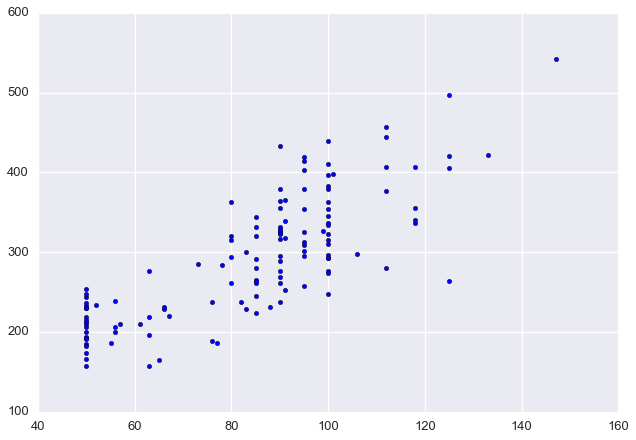

In [69]:
plt.scatter(df.crm, df.target)

In [70]:
slope, intercept, r, p, stderr = stats.linregress(df.crm, df.target)

In [71]:
mape(df.target, intercept + df.crm * slope)

-13.295509746721493

## var12 -- вес

In [72]:
normed_train.groupby(['var12', 'kmage_annuel']).size().sort_values(ascending=False).head()

var12  kmage_annuel
3211   17000           4121
960    3098            3512
890    2983            3484
980    6260            3384
1300   7211            3224
dtype: int64

In [73]:
df_index = (normed_train.kmage_annuel == 17000) &\
           (normed_train.var12 == 3211)
df = normed_train[df_index]

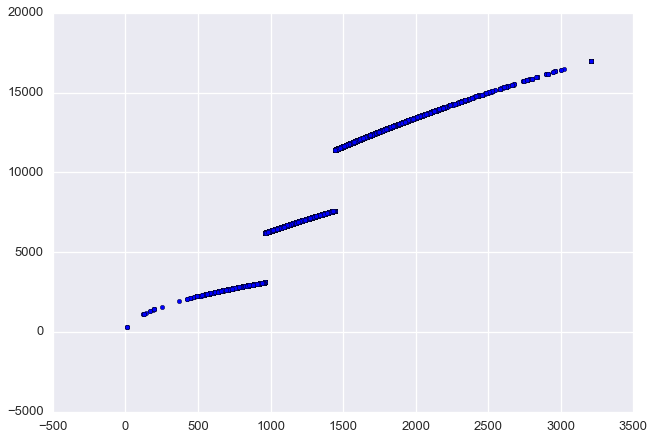

In [74]:
plt.scatter(normed_train.var12, normed_train.kmage_annuel)

В трейне kmage_annuel монотонная функция от var12. Выкинем var12

In [75]:
normed_train.drop('var12', axis=1, inplace=True)

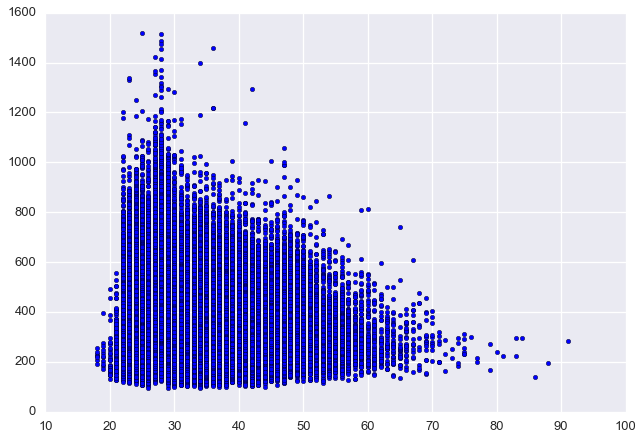

In [86]:
plt.scatter(normed_train.age, normed_train.target)

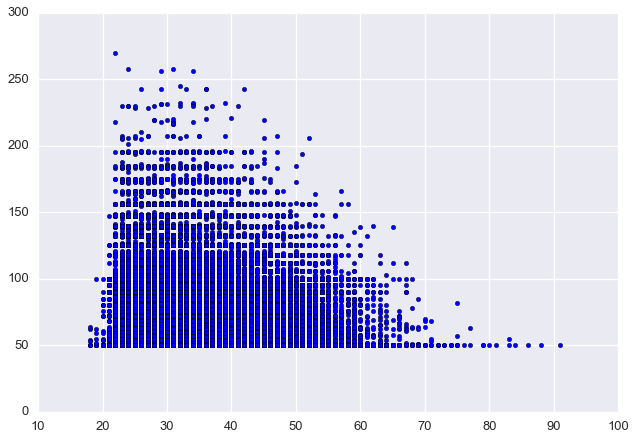

In [88]:
plt.scatter(normed_train.age, normed_train.crm)

In [97]:
df_index = normed_train.age > 70
df = normed_train[df_index]

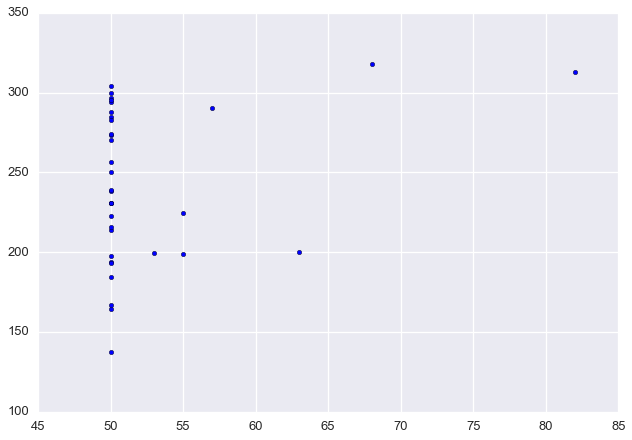

In [98]:
plt.scatter(df.crm, df.target)

In [83]:
normed_train.select_dtypes(include=[np.number]).columns

Index(['puis_fiscale', 'anc_veh', 'kmage_annuel', 'var1', 'var2', 'var3',
       'var4', 'var5', 'var7', 'var9', 'var10', 'var13', 'var15', 'var16',
       'var17', 'var18', 'var19', 'var20', 'var21', 'var22', 'department',
       'subreg', 'target', 'age', 'crm'],
      dtype='object')

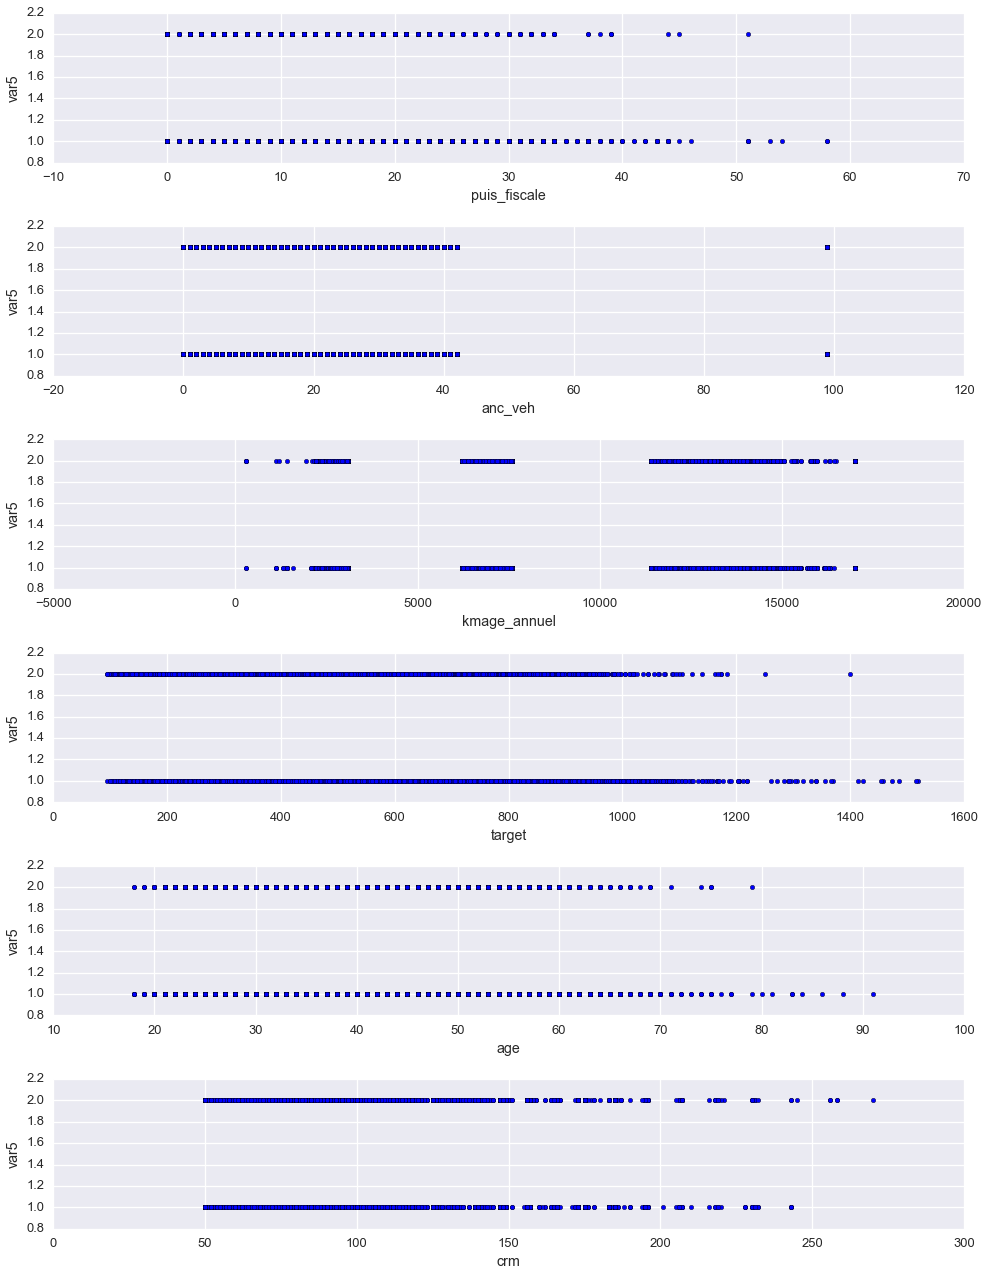

In [122]:
subject = 'var5'
cols = ['puis_fiscale', 'anc_veh', 'kmage_annuel', 'target', 'age', 'crm'] 
fig, ax = plt.subplots(len(cols), 1, figsize=(14, 18))
for index, col in enumerate(cols):
    ax[index].scatter(normed_train[col], normed_train[subject])
    ax[index].set_xlabel(col)
    ax[index].set_ylabel(subject)
plt.tight_layout()
plt.show()

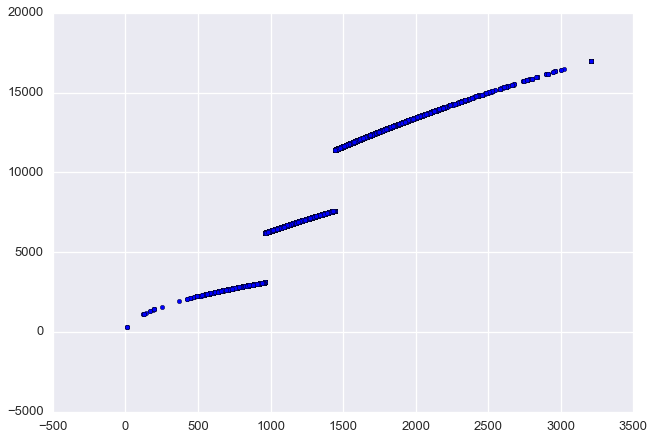

In [74]:
plt.scatter(normed_train.var12, normed_train.kmage_annuel)

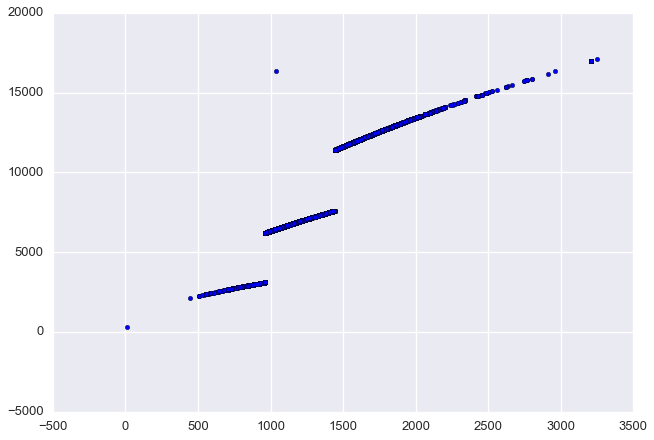

In [175]:
plt.scatter(test.var12, test.kmage_annuel)

In [29]:
normed_train.corr().target.sort_values()

anc_veh           -0.387907
var11             -0.387168
var16             -0.238613
var5              -0.143081
var1              -0.088035
var2              -0.075882
department        -0.021329
var19             -0.004300
subreg            -0.002428
var21             -0.000854
var20              0.001312
var22              0.003974
var17              0.004075
var18              0.011032
var15              0.034451
annee_naissance    0.087131
annee_permis       0.088035
var13              0.122052
var7               0.138601
var4               0.171695
puis_fiscale       0.171823
var10              0.184609
var3               0.197890
var12              0.200000
var9               0.266557
kmage_annuel       0.319890
target             1.000000
Name: target, dtype: float64

Очень сильное предположение. Пусть поправки, вносимые каждой переменной, независимы. То есть таргет есть сумма функций от каждой переменной в отдельности. Каждая такая функция есть неглубокое решающее дерево

In [32]:
validation_index = (train.department == 1) | (train.department > 90)
train_index = ~validation_index

In [33]:
target = normed_train.target

In [34]:
dummy_train = pd.get_dummies(normed_train.drop('target', axis=1))

In [35]:
dummy_train.shape

(300000, 237)

In [36]:
dummy_train.fillna(-9999, inplace=True)

In [37]:
subtrain, validation = dummy_train[train_index], dummy_train[validation_index]
x_subtrain = np.array(subtrain)
x_validation = np.array(validation)

targetsubtrain, targetvalidation = target[train_index], target[validation_index]
t_subtrain = np.array(targetsubtrain).flatten()
t_validation = np.array(targetvalidation).flatten()

In [38]:
y_validation = np.array(train.prime_tot_ttc[validation_index]).flatten()

In [39]:
del subtrain
del validation

In [40]:
gc.collect()

13213

In [41]:
from sklearn.ensemble import ExtraTreesRegressor

In [42]:
%%time
est = ExtraTreesRegressor(n_estimators=10, max_features=None, 
                          max_depth=None, n_jobs=-1, random_state=42).fit(X=x_subtrain, y=t_subtrain)

CPU times: user 2min 54s, sys: 316 ms, total: 2min 54s
Wall time: 51.2 s


In [44]:
def restore_y(pred, crm, fiscale):
    return np.exp(pred) / (1 - fiscale / 100) * crm / 100

In [45]:
target_pred = est.predict(x_validation)
y_pred = restore_y(target_pred, np.array(train.crm[validation_index]), np.array(train.puis_fiscale[validation_index]))
mape(y_validation, y_pred)

-10.757877774681447

Норм, не треш делаем, значит

In [46]:
%%time
est = ExtraTreesRegressor(n_estimators=40, max_features=None, 
                          max_depth=None, n_jobs=-1, random_state=42).fit(X=x_subtrain, y=t_subtrain)

CPU times: user 12min 23s, sys: 1.73 s, total: 12min 25s
Wall time: 3min 10s


In [47]:
target_pred = est.predict(x_validation)
y_pred = restore_y(target_pred, np.array(train.crm[validation_index]), np.array(train.puis_fiscale[validation_index]))
mape(y_validation, y_pred)

-10.314196207086255

Попробуем зафиксировать некоторые переменные и посмотреть на остальное

In [48]:
normed_train.columns

Index(['annee_naissance', 'annee_permis', 'marque', 'anc_veh', 'energie_veh',
       'kmage_annuel', 'profession', 'var1', 'var2', 'var3', 'var4', 'var5',
       'var6', 'var7', 'var8', 'var9', 'var10', 'var11', 'var12', 'var13',
       'var14', 'var15', 'var16', 'var17', 'var18', 'var19', 'var20', 'var21',
       'var22', 'department', 'subreg', 'target'],
      dtype='object')

In [78]:
normed_train.groupby(['marque', 'kmage_annuel']).size().sort_values(ascending=False)

marque      kmage_annuel
RENAULT     2983            2427
            3098            2243
            7183            1932
            7071            1912
            6260            1879
            2906            1785
PEUGEOT     6511            1687
RENAULT     6308            1603
            6324            1508
            7266            1337
PEUGEOT     6572            1314
            7141            1284
CITROEN     3074            1280
PEUGEOT     6542            1261
            2966            1245
RENAULT     7321            1228
CITROEN     6393            1209
PEUGEOT     6374            1185
RENAULT     6572            1177
            7563            1116
            6855            1102
            7402            1087
CITROEN     7211            1066
RENAULT     6526            1045
            6913            1044
PEUGEOT     6752            1043
RENAULT     6985            1019
            2810             948
PEUGEOT     7539             946
RENAULT     6496  

In [48]:
for col in normed_train.columns:
    if normed_train[col].dtype in ['int64', 'float64']:
        print(normed_train[col].nunique(), col, normed_train[col].dtype)

68 annee_naissance float64
69 annee_permis float64
44 anc_veh int64
1244 kmage_annuel int64
69 var1 float64
6 var2 int64
2 var3 int64
10 var4 int64
2 var5 int64
18 var7 float64
335 var9 int64
213 var10 int64
44 var11 int64
1244 var12 int64
4 var13 int64
10 var15 int64
6 var16 float64
6 var17 int64
46 var18 int64
29 var19 int64
2 var20 int64
2 var21 int64
25 var22 int64
97 department float64
863 subreg float64
250344 target float64


Так как у нас есть предположение о сумме функций от каждой переменной, давайте всё за one-hot-encod'им, и потом это скормим sgd с epsilon-tube

In [49]:
dummy_train = None
gc.collect()

158

In [56]:
dropped_normed_train = normed_train.drop(['target', 'subreg'], axis=1)

In [58]:
for col in dropped_normed_train.columns:
    if dropped_normed_train[col].dtype in ['float64']:
        dropped_normed_train[col] = np.int64(dropped_normed_train[col])

In [63]:
dropped_normed_train[train.department.isnull()].department

id
46316    -9223372036854775808
46317    -9223372036854775808
46318    -9223372036854775808
296254   -9223372036854775808
296255   -9223372036854775808
Name: department, dtype: int64

Норм разобрался с пропусками

Так, смысл такой. Сделать базовую обработку, перевести float в int. Записать это в файлы, не выбрасывая ни один признак.

При обучении (сначала перейти к нормальному лог-таргету, учтя налоги и КБМ, налоги и КБМ выбросить) сделать label encode для оставшихся категориальных, потом всё, вот прямо все признаки пропустить через one hot encoder в sparse матрицу. Это уже скормить линейным регрессорам. 

# Target label separation 

In [197]:
y_train = train['prime_tot_ttc']
train = train.drop('prime_tot_ttc', axis=1)

# Save to file

In [198]:
y_train.to_csv('preprocessed_csv/y_train_new.csv', sep=';')

In [199]:
train.to_csv('preprocessed_csv/train_new.csv', sep=';')

In [200]:
test.to_csv('preprocessed_csv/test_new.csv', sep=';')